2021-03-06 15:10:10 URL:https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg [182965/182965] -> "bird.png" [1]


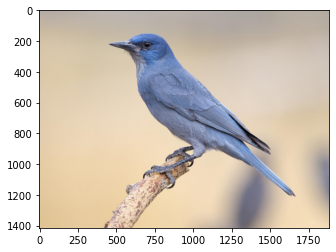

In [9]:
from torchvision import models
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

from PIL import Image
import matplotlib.pyplot as plt
import torch

!wget -nv https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg -O bird.png
img = Image.open('./bird.png')
plt.imshow(img); plt.show()



In [66]:
# Apply the transformations needed
import torchvision.transforms as T
trf = T.Compose([T.Resize(256),
                 T.CenterCrop(120),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)

In [62]:
# Pass the input through the net
out = fcn(inp)['out']
print (out.shape)

torch.Size([1, 21, 120, 120])


In [63]:
import numpy as np
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)
print (np.unique(om))

(120, 120)
[ 0 15]


In [64]:
# Define the helper function
def decode_segmap(image, nc=21):

    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb


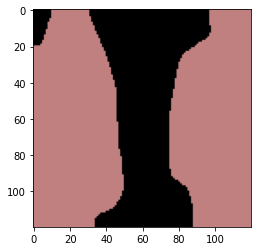

In [65]:
rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()

In [22]:
def segment(net, path, show_orig=True, dev='cpu'):
    img = Image.open(path)
    if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
    # Comment the Resize and CenterCrop for better inference results
    trf = T.Compose([T.Resize(640), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
    inp = trf(img).unsqueeze(0).to(dev)
    out = net.to(dev)(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    rgb = decode_segmap(om)
    plt.imshow(rgb); plt.axis('off'); plt.show()
    return out

2021-03-06 15:12:10 URL:https://learnopencv.com/wp-content/uploads/2021/01/horse-segmentation.jpeg [434252/434252] -> "horse.png" [1]


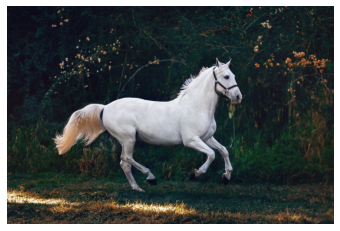

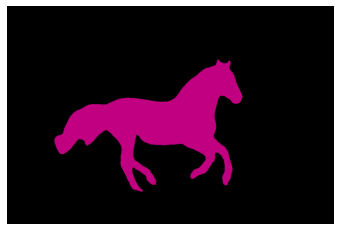

In [18]:
!wget -nv https://www.learnopencv.com/wp-content/uploads/2021/01/horse-segmentation.jpeg -O horse.png
segment(fcn, './horse.png')

In [19]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /Users/miladbohlouli/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

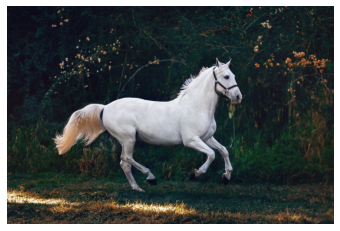

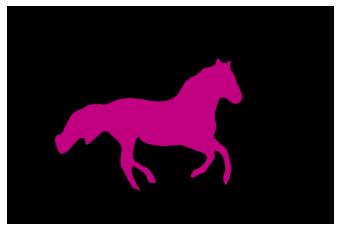

In [20]:
segment(dlab, './horse.png')

2021-03-06 15:45:07 URL:https://learnopencv.com/wp-content/uploads/2021/01/person-segmentation.jpeg [422242/422242] -> "person.png" [1]


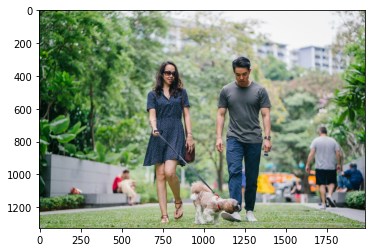

Segmenatation Image on FCN


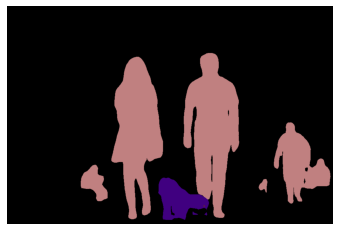

Segmenatation Image on DeepLabv3


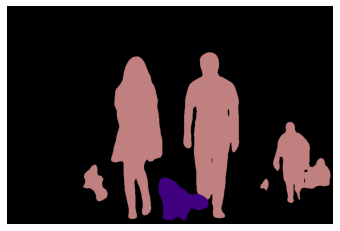

In [23]:
!wget -nv "https://www.learnopencv.com/wp-content/uploads/2021/01/person-segmentation.jpeg" -O person.png
img = Image.open('./person.png')
plt.imshow(img); plt.show()

print ('Segmenatation Image on FCN')
segment(fcn, path='./person.png', show_orig=False)

print ('Segmenatation Image on DeepLabv3')
result = segment(dlab, path='./person.png', show_orig=False)

In [33]:
result.argmax(dim=1).squeeze().unique()

tensor([ 0, 12, 15])

(1024, 2048)


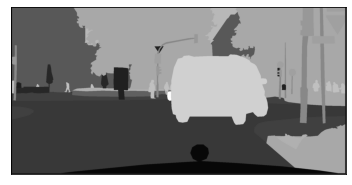

(<matplotlib.image.AxesImage at 0x1455347c0>, ([], []), ([], []), None)

In [69]:
from PIL import Image
image = Image.open("dataset/gtFine/train/aachen_000045_000019_gtFine_labelIds.png")
print(np.array(image).shape)
plt.imshow(image, cmap="gray"), plt.xticks([]), plt.yticks([]), plt.show()

In [46]:
from torchvision.datasets import Cityscapes

class MiniCity(Cityscapes):
    
    voidClass = 19
    
    # Convert ids to train_ids
    id2trainid = np.array([label.train_id for label in Cityscapes.classes if label.train_id >= 0], dtype='uint8')
    id2trainid[np.where(id2trainid==255)] = voidClass
    
    # Convert train_ids to colors
    mask_colors = [list(label.color) for label in Cityscapes.classes if label.train_id >= 0 and label.train_id <= 19]
    mask_colors.append([0,0,0])
    mask_colors = np.array(mask_colors)
    
    # Convert train_ids to ids
    trainid2id = np.zeros((256), dtype='uint8')
    for label in Cityscapes.classes:
        if label.train_id >= 0 and label.train_id < 255:
            trainid2id[label.train_id] = label.id
    
    # List of valid class ids
    validClasses = np.unique([label.train_id for label in Cityscapes.classes if label.id >= 0])
    validClasses[np.where(validClasses==255)] = voidClass
    validClasses = list(validClasses)
    
    # Create list of class names
    classLabels = [label.name for label in Cityscapes.classes if not (label.ignore_in_eval or label.id < 0)]
    classLabels.append('void')
    
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        super(Cityscapes, self).__init__(root, transforms, transform, target_transform)
        self.images_dir = os.path.join(self.root, 'leftImg8bit', split)
        self.targets_dir = os.path.join(self.root, 'gtFine', split)
        self.split = split
        self.images = []
        self.targets = []

        assert split in ['train','val','test'], 'Unknown value {} for argument split.'.format(split)

        for file_name in os.listdir(self.images_dir):
            self.images.append(os.path.join(self.images_dir, file_name))
            if split != 'test':
                target_name = '{}_{}'.format(file_name.split('_leftImg8bit')[0],
                                                 'gtFine_labelIds.png')
                self.targets.append(os.path.join(self.targets_dir, target_name))
            
    
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target)
        """

        filepath = self.images[index]
        image = Image.open(filepath).convert('RGB')
        
        if self.split != 'test':
            target = Image.open(self.targets[index])

        if self.transforms is not None:
            if self.split != 'test':
                image, target = self.transforms(image, mask=target)
                # Convert class ids to train_ids and then to tensor
                target = self.id2trainid[target]
                return image, target, filepath
            else:
                image = self.transforms(image)
                return image, filepath